In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string
import joblib

from scipy.spatial.distance import cosine

from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation

from tqdm import *

%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-knn-tf-idf-lda/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS
SEED= 42

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [8]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [9]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [10]:
# # https://github.com/scikit-learn/scikit-learn/issues/6614
# class MyTfidfVectorizer(TfidfVectorizer):
#     def fit_transform(self, X, y):
#         result = super(MyTfidfVectorizer, self).fit_transform(X, y)
#         result.sort_indices()
#         return result

In [11]:
parameters = [
    { 
        "vect__max_features": [500],
        "vect__norm": ['l1','l2',None],
        "lda__n_components":[5,10,50,100],
        "nn__n_neighbors":[1,2,3,5,10,20,30,50],
        "nn__metric":["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]
    }
]

In [12]:
len(ParameterGrid(parameters))

576

In [13]:
for g in ParameterGrid(parameters):
    print(g)
    vect=TfidfVectorizer().set_params(**dict([(re.sub('^vect__','',k),v) for (k,v) in g.items() if k.startswith('vect__') ]))
    vect.fit(X_train)
    
    X_train_vect = vect.transform(X_train)
    X_val_vect = vect.transform(X_val)
    
    number_of_components = g['lda__n_components']
    
    # cache the lda model because it's expensive to build
    if os.path.isfile(MODELS_ROOT+"/lda-{}.p".format(number_of_components)):
        lda=joblib.load(open(MODELS_ROOT+"/lda-{}.p".format(number_of_components),"rb"))
    else:
        print('calculating LDA model for {} components'.format(number_of_components))
        lda = LatentDirichletAllocation(n_components=number_of_components, learning_method='online')
        lda.fit(X_train_vect)
        joblib.dump(lda,open(MODELS_ROOT+"/lda-{}.p".format(number_of_components),"wb"))

    # these are the topic distributions
    X_train_vect = lda.transform(X_train_vect)
    X_val_vect = lda.transform(X_val_vect)
    
    nbrs = NearestNeighbors().set_params(**dict([(re.sub('^nn__','',k),v) for (k,v) in g.items() if k.startswith('nn__') ]))
    nbrs.fit(X_train_vect)
    
    # just to make it easier to use it
    k = nbrs.n_neighbors
    
    # distance matrix shape: (num_validation_documents, k)
    # indices matrix shape: (num_validation_documents, k)
    distances_matrix_val, indices_matrix_val = nbrs.kneighbors(X_val_vect)
    
    # shape: (num_validation_documents, k, num_tags)
    neighbour_labels_tensor_val = Y_train[indices_matrix_val]
        
    Y_pred_val = []
        
    # for every validation document do
    for i in range(distances_matrix_val.shape[0]):
        # these are the labels from the neighbours of test document i
        # shape: (k, num_tags)
        neighbor_labels = neighbour_labels_tensor_val[i,:,:]
        
        # these are the distances from test document i to the nearest neighbours
        # shape: (k, )
        distances_to_neighbors = distances_matrix_val[i]
        
        # sum the contributions from all neighbors, for all tags
        # no need to normalize because we're only interested in the order
        y_preds = neighbor_labels.sum(axis=0)
                    
        Y_pred_val.append(y_preds)
               
    Y_pred_val = np.array(Y_pred_val)
    
    ks = [1,2,3,4,5,6,7,8,9,10]
        
    # k is the number of neighbors so let's use at_k
    for at_k in ks:
        print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 

    
        
    print('')    

{'nn__n_neighbors': 1, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.05791505791505792
validation micro-F1 @2: 0.05415860735009671
validation micro-F1 @3: 0.04723390488515044
validation micro-F1 @4: 0.04232546825589881
validation micro-F1 @5: 0.04013247613481395
validation micro-F1 @6: 0.0377113133940182
validation micro-F1 @7: 0.037620175560819286
validation micro-F1 @8: 0.03587553386211104
validation micro-F1 @9: 0.03494302767227347
validation micro-F1 @10: 0.03265864867507578

{'nn__n_neighbors': 1, 'vect__norm': 'l2', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.04849660523763336
validation micro-F1 @2: 0.042801556420233464
validation micro-F1 @3: 0.03898635477582846
validation micro-F1 @4: 0.04089581304771178
validation micro-F1 @5: 0.037838892139652816
validation micro-F1 @6: 0.03643461288223813
validation micro-F1 @7: 0.03597824571189513
valida

validation micro-F1 @7: 0.0830270858853954
validation micro-F1 @8: 0.07900704141305645
validation micro-F1 @9: 0.07607309817254569
validation micro-F1 @10: 0.07611397972843756

{'nn__n_neighbors': 20, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.13876040703052728
validation micro-F1 @2: 0.13011152416356878
validation micro-F1 @3: 0.12779156327543426
validation micro-F1 @4: 0.12094326406724258
validation micro-F1 @5: 0.11433926897844424
validation micro-F1 @6: 0.11227521501172791
validation micro-F1 @7: 0.10724365004703669
validation micro-F1 @8: 0.10568435918559492
validation micro-F1 @9: 0.10268231349538977
validation micro-F1 @10: 0.09991500613844556

{'nn__n_neighbors': 20, 'vect__norm': 'l2', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.16087751371115175
validation micro-F1 @2: 0.14133949191685913
validation micro-F1 @3: 0.13300340241261985
valid

validation micro-F1 @4: 0.05415860735009671
validation micro-F1 @5: 0.050387596899224806
validation micro-F1 @6: 0.05007268615732515
validation micro-F1 @7: 0.04660194174757282
validation micro-F1 @8: 0.04589049411193396
validation micro-F1 @9: 0.04639119646132269
validation micro-F1 @10: 0.044133372217361716

{'nn__n_neighbors': 3, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.0690978886756238
validation micro-F1 @2: 0.05697730564944471
validation micro-F1 @3: 0.05415860735009671
validation micro-F1 @4: 0.04944255937954435
validation micro-F1 @5: 0.046222567488832786
validation micro-F1 @6: 0.043753038405444825
validation micro-F1 @7: 0.044432102193835046
validation micro-F1 @8: 0.043753038405444825
validation micro-F1 @9: 0.04237837837837838
validation micro-F1 @10: 0.041467925630293

{'nn__n_neighbors': 3, 'vect__norm': 'l2', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validatio

validation micro-F1 @1: 0.16087751371115175
validation micro-F1 @2: 0.15497478220999542
validation micro-F1 @3: 0.15130168453292497
validation micro-F1 @4: 0.13876040703052728
validation micro-F1 @5: 0.13150074294205052
validation micro-F1 @6: 0.1272106732857586
validation micro-F1 @7: 0.1223836821757099
validation micro-F1 @8: 0.11852717708942138
validation micro-F1 @9: 0.11590885443762355
validation micro-F1 @10: 0.11239328267192045

{'nn__n_neighbors': 50, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.18411552346570398
validation micro-F1 @2: 0.18000904568068749
validation micro-F1 @3: 0.16813353566009104
validation micro-F1 @4: 0.16297648938598494
validation micro-F1 @5: 0.151414920984932
validation micro-F1 @6: 0.14875019168839135
validation micro-F1 @7: 0.14170734925451905
validation micro-F1 @8: 0.13487833140208574
validation micro-F1 @9: 0.12895226286422815
validation micro-F1 @10: 0.12540762135470046

{

validation micro-F1 @10: 0.05566293003478933

{'nn__n_neighbors': 5, 'vect__norm': None, 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.0892687559354226
validation micro-F1 @2: 0.0865430337612934
validation micro-F1 @3: 0.07402680280791321
validation micro-F1 @4: 0.06538461538461539
validation micro-F1 @5: 0.062403697996918334
validation micro-F1 @6: 0.05885190545103714
validation micro-F1 @7: 0.05630692796025393
validation micro-F1 @8: 0.05415860735009671
validation micro-F1 @9: 0.05394948952176249
validation micro-F1 @10: 0.053405572755417956

{'nn__n_neighbors': 10, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.10367577756833177
validation micro-F1 @2: 0.10724365004703669
validation micro-F1 @3: 0.09889763779527559
validation micro-F1 @4: 0.0946969696969697
validation micro-F1 @5: 0.08636104241963097
validation micro-F1 @6: 0.08289661743687471
valida

validation micro-F1 @7: 0.03597824571189513
validation micro-F1 @8: 0.03491637162739592
validation micro-F1 @9: 0.03344917463075586
validation micro-F1 @10: 0.03188887802015064

{'nn__n_neighbors': 1, 'vect__norm': None, 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.04849660523763336
validation micro-F1 @2: 0.04089581304771178
validation micro-F1 @3: 0.047865459249676584
validation micro-F1 @4: 0.04754973313925279
validation micro-F1 @5: 0.043943223799338904
validation micro-F1 @6: 0.04121369462923901
validation micro-F1 @7: 0.038440111420612814
validation micro-F1 @8: 0.037073170731707315
validation micro-F1 @9: 0.03600867678958785
validation micro-F1 @10: 0.035923467395548615

{'nn__n_neighbors': 2, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.07648183556405354
validation micro-F1 @2: 0.06165703275529865
validation micro-F1 @3: 0.05853972338372467
validation micr

validation micro-F1 @4: 0.12706539446125203
validation micro-F1 @5: 0.12278410151147602
validation micro-F1 @6: 0.11757367846561671
validation micro-F1 @7: 0.11054467400053662
validation micro-F1 @8: 0.10768869033623325
validation micro-F1 @9: 0.10327851681156384
validation micro-F1 @10: 0.10027381739212539

{'nn__n_neighbors': 20, 'vect__norm': None, 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.16924476797088261
validation micro-F1 @2: 0.1396208969024503
validation micro-F1 @3: 0.13069061628987302
validation micro-F1 @4: 0.12313432835820895
validation micro-F1 @5: 0.11681018345189068
validation micro-F1 @6: 0.1107981220657277
validation micro-F1 @7: 0.10673477617959404
validation micro-F1 @8: 0.10412249705535924
validation micro-F1 @9: 0.10069225928256766
validation micro-F1 @10: 0.09919697685403873

{'nn__n_neighbors': 30, 'vect__norm': 'l1', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 

validation micro-F1 @1: 0.07279693486590039
validation micro-F1 @2: 0.06538461538461539
validation micro-F1 @3: 0.055412371134020616
validation micro-F1 @4: 0.053217223028543786
validation micro-F1 @5: 0.05302883684923553
validation micro-F1 @6: 0.05478569126651627
validation micro-F1 @7: 0.05254424778761062
validation micro-F1 @8: 0.05180343742435246
validation micro-F1 @9: 0.05206540447504303
validation micro-F1 @10: 0.050009691800736576

{'nn__n_neighbors': 3, 'vect__norm': None, 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.0690978886756238
validation micro-F1 @2: 0.06165703275529865
validation micro-F1 @3: 0.056664520283322604
validation micro-F1 @4: 0.05085977234197142
validation micro-F1 @5: 0.050009691800736576
validation micro-F1 @6: 0.05007268615732515
validation micro-F1 @7: 0.04849660523763336
validation micro-F1 @8: 0.04849660523763336
validation micro-F1 @9: 0.04849660523763336
validation micro-F1 @10: 0.04849660523763336

validation micro-F1 @1: 0.20677361853832443
validation micro-F1 @2: 0.18820351193156237
validation micro-F1 @3: 0.17201695941853423
validation micro-F1 @4: 0.16297648938598494
validation micro-F1 @5: 0.1503952932524361
validation micro-F1 @6: 0.1441967717140661
validation micro-F1 @7: 0.14048059149722736
validation micro-F1 @8: 0.13617415470125058
validation micro-F1 @9: 0.13223310985043837
validation micro-F1 @10: 0.12872023809523808

{'nn__n_neighbors': 50, 'vect__norm': None, 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.18575293056807934
validation micro-F1 @2: 0.1873873873873874
validation micro-F1 @3: 0.17753623188405798
validation micro-F1 @4: 0.16966113259040255
validation micro-F1 @5: 0.16020482809070957
validation micro-F1 @6: 0.15328132170720515
validation micro-F1 @7: 0.14659823661008028
validation micro-F1 @8: 0.13897560411608278
validation micro-F1 @9: 0.13377305987838814
validation micro-F1 @10: 0.12854618175053484

{'nn

validation micro-F1 @10: 0.07168870998658233

{'nn__n_neighbors': 10, 'vect__norm': 'l2', 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.1283720930232558
validation micro-F1 @2: 0.10902255639097744
validation micro-F1 @3: 0.106055851898337
validation micro-F1 @4: 0.09739952718676123
validation micro-F1 @5: 0.09433604849403296
validation micro-F1 @6: 0.09319222871584268
validation micro-F1 @7: 0.0877121520706042
validation micro-F1 @8: 0.08608799048751486
validation micro-F1 @9: 0.08401227383345677
validation micro-F1 @10: 0.0814341565748069

{'nn__n_neighbors': 10, 'vect__norm': None, 'lda__n_components': 5, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.13703703703703704
validation micro-F1 @2: 0.10724365004703669
validation micro-F1 @3: 0.10128971374646115
validation micro-F1 @4: 0.09649952696310313
validation micro-F1 @5: 0.09071930157525147
validation micro-F1 @6: 0.08684627575277337
validatio

validation micro-F1 @7: 0.044160533259269545
validation micro-F1 @8: 0.04422843256379101
validation micro-F1 @9: 0.04195501730103806
validation micro-F1 @10: 0.04108655437639957

{'nn__n_neighbors': 2, 'vect__norm': 'l2', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.042801556420233464
validation micro-F1 @2: 0.04470359572400389
validation micro-F1 @3: 0.04089581304771178
validation micro-F1 @4: 0.043753038405444825
validation micro-F1 @5: 0.04203970416504477
validation micro-F1 @6: 0.042484190043781414
validation micro-F1 @7: 0.04307350284840906
validation micro-F1 @8: 0.042563541286635045
validation micro-F1 @9: 0.0440699935191186
validation micro-F1 @10: 0.043753038405444825

{'nn__n_neighbors': 2, 'vect__norm': None, 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.06724303554274735
validation micro-F1 @2: 0.05697730564944471
validation micro-F1 @3: 0.05916398713826366

validation micro-F1 @1: 0.14391143911439114
validation micro-F1 @2: 0.14988505747126438
validation micro-F1 @3: 0.13703703703703704
validation micro-F1 @4: 0.13271461716937355
validation micro-F1 @5: 0.13045902248652666
validation micro-F1 @6: 0.12342608425307011
validation micro-F1 @7: 0.11862142666310446
validation micro-F1 @8: 0.11654575239878305
validation micro-F1 @9: 0.11688851913477537
validation micro-F1 @10: 0.11398575178102738

{'nn__n_neighbors': 30, 'vect__norm': 'l2', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.19389587073608616
validation micro-F1 @2: 0.16507067943456452
validation micro-F1 @3: 0.15016855654305852
validation micro-F1 @4: 0.14048059149722736
validation micro-F1 @5: 0.13738196630253657
validation micro-F1 @6: 0.13069061628987302
validation micro-F1 @7: 0.1293664497277195
validation micro-F1 @8: 0.12641136072634152
validation micro-F1 @9: 0.12274517934895293
validation micro-F1 @10: 0.1180432139182

validation micro-F1 @10: 0.04849660523763336

{'nn__n_neighbors': 5, 'vect__norm': 'l1', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.09289099526066351
validation micro-F1 @2: 0.08289661743687471
validation micro-F1 @3: 0.08320101619561765
validation micro-F1 @4: 0.07187350263536177
validation micro-F1 @5: 0.0676142912024587
validation micro-F1 @6: 0.06321193646719075
validation micro-F1 @7: 0.059520529071369524
validation micro-F1 @8: 0.05861777831383428
validation micro-F1 @9: 0.05478569126651627
validation micro-F1 @10: 0.053217223028543786

{'nn__n_neighbors': 5, 'vect__norm': 'l2', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.09649952696310313
validation micro-F1 @2: 0.0892687559354226
validation micro-F1 @3: 0.0789306174411203
validation micro-F1 @4: 0.07279693486590039
validation micro-F1 @5: 0.06724303554274735
validation micro-F1 @6: 0.06693354683746998
validation 

validation micro-F1 @7: 0.14537792994469317
validation micro-F1 @8: 0.13832986352070323
validation micro-F1 @9: 0.1339653751030503
validation micro-F1 @10: 0.12906825367305189

{'nn__n_neighbors': 1, 'vect__norm': 'l1', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.06538461538461539
validation micro-F1 @2: 0.04849660523763336
validation micro-F1 @3: 0.047865459249676584
validation micro-F1 @4: 0.042801556420233464
validation micro-F1 @5: 0.04089581304771178
validation micro-F1 @6: 0.03866774979691308
validation micro-F1 @7: 0.036525860867140665
validation micro-F1 @8: 0.03467643467643468
validation micro-F1 @9: 0.03302194221160113
validation micro-F1 @10: 0.03073309190564745

{'nn__n_neighbors': 1, 'vect__norm': 'l2', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.05415860735009671
validation micro-F1 @2: 0.051331719128329296
validation micro-F1 @3: 0.050387596899224806


validation micro-F1 @1: 0.13531047265987026
validation micro-F1 @2: 0.10724365004703669
validation micro-F1 @3: 0.10128971374646115
validation micro-F1 @4: 0.09604920747575113
validation micro-F1 @5: 0.09108159392789374
validation micro-F1 @6: 0.0865430337612934
validation micro-F1 @7: 0.08276613122787911
validation micro-F1 @8: 0.07808955223880597
validation micro-F1 @9: 0.07525510204081633
validation micro-F1 @10: 0.0757459831675593

{'nn__n_neighbors': 20, 'vect__norm': 'l1', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.11433926897844424
validation micro-F1 @2: 0.1292422129242213
validation micro-F1 @3: 0.12313432835820895
validation micro-F1 @4: 0.11830722469020341
validation micro-F1 @5: 0.11044327573253193
validation micro-F1 @6: 0.10842995926041993
validation micro-F1 @7: 0.10749798441279226
validation micro-F1 @8: 0.1034523388712148
validation micro-F1 @9: 0.10029374737725556
validation micro-F1 @10: 0.0973995271867612

validation micro-F1 @10: 0.043753038405444825

{'nn__n_neighbors': 2, 'vect__norm': None, 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.06724303554274735
validation micro-F1 @2: 0.05697730564944471
validation micro-F1 @3: 0.059163987138263666
validation micro-F1 @4: 0.055099081681971966
validation micro-F1 @5: 0.05265195509097948
validation micro-F1 @6: 0.051331719128329296
validation micro-F1 @7: 0.047685056833934016
validation micro-F1 @8: 0.04636485010316786
validation micro-F1 @9: 0.04660194174757282
validation micro-F1 @10: 0.044133372217361716

{'nn__n_neighbors': 3, 'vect__norm': 'l1', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.08563273073263558
validation micro-F1 @2: 0.06724303554274735
validation micro-F1 @3: 0.05791505791505792
validation micro-F1 @4: 0.055099081681971966
validation micro-F1 @5: 0.05302883684923553
validation micro-F1 @6: 0.050702405942192795
validation

validation micro-F1 @7: 0.1293664497277195
validation micro-F1 @8: 0.12641136072634152
validation micro-F1 @9: 0.12274517934895293
validation micro-F1 @10: 0.118043213918249

{'nn__n_neighbors': 30, 'vect__norm': None, 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.16255707762557078
validation micro-F1 @2: 0.15582034830430797
validation micro-F1 @3: 0.15016855654305852
validation micro-F1 @4: 0.13703703703703704
validation micro-F1 @5: 0.12976389663506227
validation micro-F1 @6: 0.12546583850931678
validation micro-F1 @7: 0.12188291772236298
validation micro-F1 @8: 0.1187470780738663
validation micro-F1 @9: 0.11630084260896702
validation micro-F1 @10: 0.11310137859889337

{'nn__n_neighbors': 50, 'vect__norm': 'l1', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.18575293056807934
validation micro-F1 @2: 0.18165386353366472
validation micro-F1 @3: 0.1631162507608034
validation micro-F1 @

validation micro-F1 @4: 0.07279693486590039
validation micro-F1 @5: 0.06724303554274735
validation micro-F1 @6: 0.06693354683746998
validation micro-F1 @7: 0.06325632563256325
validation micro-F1 @8: 0.06048921556814074
validation micro-F1 @9: 0.05895594383106442
validation micro-F1 @10: 0.05678964651342476

{'nn__n_neighbors': 5, 'vect__norm': None, 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.09108159392789374
validation micro-F1 @2: 0.0865430337612934
validation micro-F1 @3: 0.07402680280791321
validation micro-F1 @4: 0.06491945179129599
validation micro-F1 @5: 0.06128348429369821
validation micro-F1 @6: 0.05760257441673371
validation micro-F1 @7: 0.05603864734299517
validation micro-F1 @8: 0.05462895818225767
validation micro-F1 @9: 0.05394948952176249
validation micro-F1 @10: 0.053782162894176824

{'nn__n_neighbors': 10, 'vect__norm': 'l1', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-

validation micro-F1 @1: 0.05415860735009671
validation micro-F1 @2: 0.051331719128329296
validation micro-F1 @3: 0.050387596899224806
validation micro-F1 @4: 0.051331719128329296
validation micro-F1 @5: 0.04432348367029549
validation micro-F1 @6: 0.04153147306943543
validation micro-F1 @7: 0.0422574367528496
validation micro-F1 @8: 0.04089581304771178
validation micro-F1 @9: 0.03919870059556037
validation micro-F1 @10: 0.03688164698995024

{'nn__n_neighbors': 1, 'vect__norm': None, 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.05415860735009671
validation micro-F1 @2: 0.04660194174757282
validation micro-F1 @3: 0.04975767366720517
validation micro-F1 @4: 0.04896969696969697
validation micro-F1 @5: 0.04432348367029549
validation micro-F1 @6: 0.04184914841849149
validation micro-F1 @7: 0.039259362383405265
validation micro-F1 @8: 0.037551816630090225
validation micro-F1 @9: 0.03600867678958785
validation micro-F1 @10: 0.036115178

validation micro-F1 @10: 0.09739952718676123

{'nn__n_neighbors': 20, 'vect__norm': 'l2', 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.15582034830430797
validation micro-F1 @2: 0.1456221198156682
validation micro-F1 @3: 0.13703703703703704
validation micro-F1 @4: 0.12967696955612362
validation micro-F1 @5: 0.12348442454765902
validation micro-F1 @6: 0.11639881416757684
validation micro-F1 @7: 0.11054467400053662
validation micro-F1 @8: 0.10657569697682626
validation micro-F1 @9: 0.10307982401005657
validation micro-F1 @10: 0.09973554967888175

{'nn__n_neighbors': 20, 'vect__norm': None, 'lda__n_components': 10, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.1709090909090909
validation micro-F1 @2: 0.14048059149722736
validation micro-F1 @3: 0.13358070500927643
validation micro-F1 @4: 0.12488350419384903
validation micro-F1 @5: 0.11575201348567148
validation micro-F1 @6: 0.11020663744520977
vali

validation micro-F1 @4: 0.060722891566265064
validation micro-F1 @5: 0.05754006564973933
validation micro-F1 @6: 0.056351634197391726
validation micro-F1 @7: 0.056575134538429696
validation micro-F1 @8: 0.05603864734299517
validation micro-F1 @9: 0.0558299334335409
validation micro-F1 @10: 0.053782162894176824

{'nn__n_neighbors': 3, 'vect__norm': 'l2', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.05978784956605593
validation micro-F1 @2: 0.05603864734299517
validation micro-F1 @3: 0.051646223369916075
validation micro-F1 @4: 0.04849660523763336
validation micro-F1 @5: 0.048875096974398756
validation micro-F1 @6: 0.047865459249676584
validation micro-F1 @7: 0.047685056833934016
validation micro-F1 @8: 0.04731287152735655
validation micro-F1 @9: 0.047865459249676584
validation micro-F1 @10: 0.04717072697272639

{'nn__n_neighbors': 3, 'vect__norm': None, 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'citybloc

validation micro-F1 @1: 0.17257039055404177
validation micro-F1 @2: 0.16674259681093395
validation micro-F1 @3: 0.1552567237163814
validation micro-F1 @4: 0.15200918484500575
validation micro-F1 @5: 0.14835265967237254
validation micro-F1 @6: 0.14334051061211936
validation micro-F1 @7: 0.1372834281179738
validation micro-F1 @8: 0.13336425837875449
validation micro-F1 @9: 0.12991841371475782
validation micro-F1 @10: 0.12558226197130612

{'nn__n_neighbors': 50, 'vect__norm': 'l2', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.21155555555555555
validation micro-F1 @2: 0.1873873873873874
validation micro-F1 @3: 0.17257039055404177
validation micro-F1 @4: 0.16381473876340405
validation micro-F1 @5: 0.1520940484937546
validation micro-F1 @6: 0.1430549146285187
validation micro-F1 @7: 0.13802221047065044
validation micro-F1 @8: 0.13336425837875449
validation micro-F1 @9: 0.13184772516248838
validation micro-F1 @10: 0.1275011633317822


validation micro-F1 @10: 0.053782162894176824

{'nn__n_neighbors': 10, 'vect__norm': 'l1', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.1575091575091575
validation micro-F1 @2: 0.1275011633317822
validation micro-F1 @3: 0.11551670309085232
validation micro-F1 @4: 0.10456900612341027
validation micro-F1 @5: 0.09793911892607299
validation micro-F1 @6: 0.09077969318361537
validation micro-F1 @7: 0.08511216859279402
validation micro-F1 @8: 0.08358137873556376
validation micro-F1 @9: 0.07872679045092838
validation micro-F1 @10: 0.07629792523185773

{'nn__n_neighbors': 10, 'vect__norm': 'l2', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.11433926897844424
validation micro-F1 @2: 0.11345522737927802
validation micro-F1 @3: 0.1018867924528302
validation micro-F1 @4: 0.09694963348309293
validation micro-F1 @5: 0.09216764650104305
validation micro-F1 @6: 0.09168510907366424
validation

validation micro-F1 @7: 0.039259362383405265
validation micro-F1 @8: 0.037551816630090225
validation micro-F1 @9: 0.03600867678958785
validation micro-F1 @10: 0.03611517813567594

{'nn__n_neighbors': 2, 'vect__norm': 'l1', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.08198284080076262
validation micro-F1 @2: 0.05885190545103714
validation micro-F1 @3: 0.05728999034438365
validation micro-F1 @4: 0.05697730564944471
validation micro-F1 @5: 0.05754006564973933
validation micro-F1 @6: 0.05478569126651627
validation micro-F1 @7: 0.05442740710042824
validation micro-F1 @8: 0.05251058681185723
validation micro-F1 @9: 0.049547608789314954
validation micro-F1 @10: 0.04641227303621711

{'nn__n_neighbors': 2, 'vect__norm': 'l2', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.042801556420233464
validation micro-F1 @2: 0.04470359572400389
validation micro-F1 @3: 0.04089581304771178


validation micro-F1 @1: 0.1709090909090909
validation micro-F1 @2: 0.14048059149722736
validation micro-F1 @3: 0.13358070500927643
validation micro-F1 @4: 0.12488350419384903
validation micro-F1 @5: 0.11575201348567148
validation micro-F1 @6: 0.11020663744520977
validation micro-F1 @7: 0.10571620712844654
validation micro-F1 @8: 0.10456900612341027
validation micro-F1 @9: 0.10089145254326166
validation micro-F1 @10: 0.09991500613844556

{'nn__n_neighbors': 30, 'vect__norm': 'l1', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.17588395285584768
validation micro-F1 @2: 0.15328132170720515
validation micro-F1 @3: 0.14276923076923076
validation micro-F1 @4: 0.13531047265987026
validation micro-F1 @5: 0.13150074294205052
validation micro-F1 @6: 0.12866222291117657
validation micro-F1 @7: 0.12687857427849447
validation micro-F1 @8: 0.12379065159109454
validation micro-F1 @9: 0.12118696825067442
validation micro-F1 @10: 0.1182192293303

validation micro-F1 @10: 0.04717072697272639

{'nn__n_neighbors': 3, 'vect__norm': None, 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.06538461538461539
validation micro-F1 @2: 0.05978784956605593
validation micro-F1 @3: 0.05478569126651627
validation micro-F1 @4: 0.05085977234197142
validation micro-F1 @5: 0.048875096974398756
validation micro-F1 @6: 0.04975767366720517
validation micro-F1 @7: 0.048226164079822616
validation micro-F1 @8: 0.0496789046407367
validation micro-F1 @9: 0.0491273432449903
validation micro-F1 @10: 0.04868586945980021

{'nn__n_neighbors': 5, 'vect__norm': 'l1', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.10902255639097744
validation micro-F1 @2: 0.0955986748698533
validation micro-F1 @3: 0.08684627575277337
validation micro-F1 @4: 0.07556193208990913
validation micro-F1 @5: 0.06946843216273269
validation micro-F1 @6: 0.06631427198462278
validation micro-F1

validation micro-F1 @7: 0.13802221047065044
validation micro-F1 @8: 0.13336425837875449
validation micro-F1 @9: 0.13184772516248838
validation micro-F1 @10: 0.1275011633317822

{'nn__n_neighbors': 50, 'vect__norm': None, 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.19227313566936208
validation micro-F1 @2: 0.18983355825461087
validation micro-F1 @3: 0.1780863265922125
validation micro-F1 @4: 0.16966113259040255
validation micro-F1 @5: 0.16087751371115175
validation micro-F1 @6: 0.15328132170720515
validation micro-F1 @7: 0.14537792994469317
validation micro-F1 @8: 0.13832986352070323
validation micro-F1 @9: 0.1339653751030503
validation micro-F1 @10: 0.12906825367305189

{'nn__n_neighbors': 1, 'vect__norm': 'l1', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.06538461538461539
validation micro-F1 @2: 0.05885190545103714
validation micro-F1 @3: 0.05978784956605593
validation micro-F1 

validation micro-F1 @4: 0.09694963348309293
validation micro-F1 @5: 0.09216764650104305
validation micro-F1 @6: 0.09168510907366424
validation micro-F1 @7: 0.08745247148288973
validation micro-F1 @8: 0.08540501962650172
validation micro-F1 @9: 0.08177966101694915
validation micro-F1 @10: 0.07886947388522868

{'nn__n_neighbors': 10, 'vect__norm': None, 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.13531047265987026
validation micro-F1 @2: 0.10724365004703669
validation micro-F1 @3: 0.10128971374646115
validation micro-F1 @4: 0.09604920747575113
validation micro-F1 @5: 0.09108159392789374
validation micro-F1 @6: 0.0865430337612934
validation micro-F1 @7: 0.08276613122787911
validation micro-F1 @8: 0.07808955223880597
validation micro-F1 @9: 0.07525510204081633
validation micro-F1 @10: 0.0757459831675593

{'nn__n_neighbors': 20, 'vect__norm': 'l1', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F

validation micro-F1 @1: 0.042801556420233464
validation micro-F1 @2: 0.04470359572400389
validation micro-F1 @3: 0.04089581304771178
validation micro-F1 @4: 0.043753038405444825
validation micro-F1 @5: 0.04203970416504477
validation micro-F1 @6: 0.042484190043781414
validation micro-F1 @7: 0.04307350284840906
validation micro-F1 @8: 0.042563541286635045
validation micro-F1 @9: 0.0440699935191186
validation micro-F1 @10: 0.043753038405444825

{'nn__n_neighbors': 2, 'vect__norm': None, 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.06724303554274735
validation micro-F1 @2: 0.05697730564944471
validation micro-F1 @3: 0.059163987138263666
validation micro-F1 @4: 0.055099081681971966
validation micro-F1 @5: 0.05265195509097948
validation micro-F1 @6: 0.051331719128329296
validation micro-F1 @7: 0.047685056833934016
validation micro-F1 @8: 0.04636485010316786
validation micro-F1 @9: 0.04660194174757282
validation micro-F1 @10: 0.04413

validation micro-F1 @10: 0.11786716557530402

{'nn__n_neighbors': 30, 'vect__norm': 'l2', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.19389587073608616
validation micro-F1 @2: 0.16507067943456452
validation micro-F1 @3: 0.15016855654305852
validation micro-F1 @4: 0.14048059149722736
validation micro-F1 @5: 0.13738196630253657
validation micro-F1 @6: 0.13069061628987302
validation micro-F1 @7: 0.1293664497277195
validation micro-F1 @8: 0.12641136072634152
validation micro-F1 @9: 0.12255054432348367
validation micro-F1 @10: 0.11786716557530402

{'nn__n_neighbors': 30, 'vect__norm': None, 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.16255707762557078
validation micro-F1 @2: 0.15582034830430797
validation micro-F1 @3: 0.15016855654305852
validation micro-F1 @4: 0.13703703703703704
validation micro-F1 @5: 0.12976389663506227
validation micro-F1 @6: 0.12546583850931678
val

validation micro-F1 @4: 0.07371948300622308
validation micro-F1 @5: 0.07057920981971615
validation micro-F1 @6: 0.06724303554274735
validation micro-F1 @7: 0.06298996011552743
validation micro-F1 @8: 0.0590859761244423
validation micro-F1 @9: 0.05770674675533626
validation micro-F1 @10: 0.05697730564944471

{'nn__n_neighbors': 5, 'vect__norm': 'l2', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
validation micro-F1 @1: 0.09649952696310313
validation micro-F1 @2: 0.0892687559354226
validation micro-F1 @3: 0.0789306174411203
validation micro-F1 @4: 0.07279693486590039
validation micro-F1 @5: 0.06724303554274735
validation micro-F1 @6: 0.06693354683746998
validation micro-F1 @7: 0.06325632563256325
validation micro-F1 @8: 0.06048921556814074
validation micro-F1 @9: 0.05895594383106442
validation micro-F1 @10: 0.05678964651342476

{'nn__n_neighbors': 5, 'vect__norm': None, 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'cityblock'}
valid

validation micro-F1 @1: 0.021632251720747297
validation micro-F1 @2: 0.016757023164120255
validation micro-F1 @3: 0.013820335636722606
validation micro-F1 @4: 0.011857707509881422
validation micro-F1 @5: 0.010678267747676488
validation micro-F1 @6: 0.013166556945358789
validation micro-F1 @7: 0.011296243998870376
validation micro-F1 @8: 0.011612106238418777
validation micro-F1 @9: 0.012730465320456541
validation micro-F1 @10: 0.012446903091968784

{'nn__n_neighbors': 1, 'vect__norm': 'l2', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.05415860735009671
validation micro-F1 @2: 0.050387596899224806
validation micro-F1 @3: 0.0491273432449903
validation micro-F1 @4: 0.050387596899224806
validation micro-F1 @5: 0.043943223799338904
validation micro-F1 @6: 0.04121369462923901
validation micro-F1 @7: 0.0411682892906815
validation micro-F1 @8: 0.03994154895275207
validation micro-F1 @9: 0.038349041273968154
validation micro-F1 @10: 0.036

validation micro-F1 @10: 0.07427258805513016

{'nn__n_neighbors': 20, 'vect__norm': 'l1', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.11962616822429907
validation micro-F1 @2: 0.1292422129242213
validation micro-F1 @3: 0.12604781123874573
validation micro-F1 @4: 0.12006540527914039
validation micro-F1 @5: 0.11575201348567148
validation micro-F1 @6: 0.10991075622357914
validation micro-F1 @7: 0.10622562861368831
validation micro-F1 @8: 0.10031865927062433
validation micro-F1 @9: 0.09809893918706018
validation micro-F1 @10: 0.09505775421321719

{'nn__n_neighbors': 20, 'vect__norm': 'l2', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'cosine'}
validation micro-F1 @1: 0.15582034830430797
validation micro-F1 @2: 0.1456221198156682
validation micro-F1 @3: 0.13703703703703704
validation micro-F1 @4: 0.12967696955612362
validation micro-F1 @5: 0.12348442454765902
validation micro-F1 @6: 0.11639881416757684
validati

validation micro-F1 @4: 0.055099081681971966
validation micro-F1 @5: 0.05265195509097948
validation micro-F1 @6: 0.051331719128329296
validation micro-F1 @7: 0.047685056833934016
validation micro-F1 @8: 0.04636485010316786
validation micro-F1 @9: 0.04660194174757282
validation micro-F1 @10: 0.044133372217361716

{'nn__n_neighbors': 3, 'vect__norm': 'l1', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.06352261790182868
validation micro-F1 @2: 0.04849660523763336
validation micro-F1 @3: 0.045969569439948205
validation micro-F1 @4: 0.042801556420233464
validation micro-F1 @5: 0.043562816024893036
validation micro-F1 @6: 0.04470359572400389
validation micro-F1 @7: 0.04605993340732519
validation micro-F1 @8: 0.045415907710989675
validation micro-F1 @9: 0.04618040569702201
validation micro-F1 @10: 0.046791573633627806

{'nn__n_neighbors': 3, 'vect__norm': 'l2', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'eucli

validation micro-F1 @1: 0.16255707762557078
validation micro-F1 @2: 0.15582034830430797
validation micro-F1 @3: 0.15016855654305852
validation micro-F1 @4: 0.13703703703703704
validation micro-F1 @5: 0.12976389663506227
validation micro-F1 @6: 0.12546583850931678
validation micro-F1 @7: 0.12188291772236298
validation micro-F1 @8: 0.1187470780738663
validation micro-F1 @9: 0.11630084260896702
validation micro-F1 @10: 0.11310137859889337

{'nn__n_neighbors': 50, 'vect__norm': 'l1', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'euclidean'}
validation micro-F1 @1: 0.18083182640144665
validation micro-F1 @2: 0.17505668934240362
validation micro-F1 @3: 0.15919487648673375
validation micro-F1 @4: 0.14604929739691316
validation micro-F1 @5: 0.14322628276116647
validation micro-F1 @6: 0.13789912077741787
validation micro-F1 @7: 0.13679058076465142
validation micro-F1 @8: 0.13422974382751826
validation micro-F1 @9: 0.13088356729975226
validation micro-F1 @10: 0.127675414107

validation micro-F1 @10: 0.05678964651342476

{'nn__n_neighbors': 5, 'vect__norm': None, 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.09108159392789374
validation micro-F1 @2: 0.0865430337612934
validation micro-F1 @3: 0.07402680280791321
validation micro-F1 @4: 0.06491945179129599
validation micro-F1 @5: 0.06128348429369821
validation micro-F1 @6: 0.05760257441673371
validation micro-F1 @7: 0.05603864734299517
validation micro-F1 @8: 0.05462895818225767
validation micro-F1 @9: 0.05394948952176249
validation micro-F1 @10: 0.053782162894176824

{'nn__n_neighbors': 10, 'vect__norm': 'l1', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'l1'}
validation micro-F1 @1: 0.11786716557530402
validation micro-F1 @2: 0.1018867924528302
validation micro-F1 @3: 0.10486656200941916
validation micro-F1 @4: 0.09784920822500591
validation micro-F1 @5: 0.09433604849403296
validation micro-F1 @6: 0.09047769693135084
validation micro

validation micro-F1 @7: 0.0422574367528496
validation micro-F1 @8: 0.04089581304771178
validation micro-F1 @9: 0.03919870059556037
validation micro-F1 @10: 0.03688164698995024

{'nn__n_neighbors': 1, 'vect__norm': None, 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.05415860735009671
validation micro-F1 @2: 0.04660194174757282
validation micro-F1 @3: 0.04975767366720517
validation micro-F1 @4: 0.04896969696969697
validation micro-F1 @5: 0.04432348367029549
validation micro-F1 @6: 0.04184914841849149
validation micro-F1 @7: 0.039259362383405265
validation micro-F1 @8: 0.037551816630090225
validation micro-F1 @9: 0.03600867678958785
validation micro-F1 @10: 0.03611517813567594

{'nn__n_neighbors': 2, 'vect__norm': 'l1', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.06538461538461539
validation micro-F1 @2: 0.055099081681971966
validation micro-F1 @3: 0.05978784956605593
validation mic

validation micro-F1 @4: 0.12967696955612362
validation micro-F1 @5: 0.12348442454765902
validation micro-F1 @6: 0.11639881416757684
validation micro-F1 @7: 0.11054467400053662
validation micro-F1 @8: 0.10657569697682626
validation micro-F1 @9: 0.10307982401005657
validation micro-F1 @10: 0.09973554967888175

{'nn__n_neighbors': 20, 'vect__norm': None, 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micro-F1 @1: 0.1709090909090909
validation micro-F1 @2: 0.14048059149722736
validation micro-F1 @3: 0.13358070500927643
validation micro-F1 @4: 0.12488350419384903
validation micro-F1 @5: 0.11575201348567148
validation micro-F1 @6: 0.11020663744520977
validation micro-F1 @7: 0.10571620712844654
validation micro-F1 @8: 0.10456900612341027
validation micro-F1 @9: 0.10089145254326166
validation micro-F1 @10: 0.09991500613844556

{'nn__n_neighbors': 30, 'vect__norm': 'l1', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'l2'}
validation micr

validation micro-F1 @1: 0.05978784956605593
validation micro-F1 @2: 0.05603864734299517
validation micro-F1 @3: 0.051646223369916075
validation micro-F1 @4: 0.04849660523763336
validation micro-F1 @5: 0.048875096974398756
validation micro-F1 @6: 0.047865459249676584
validation micro-F1 @7: 0.047685056833934016
validation micro-F1 @8: 0.04731287152735655
validation micro-F1 @9: 0.047865459249676584
validation micro-F1 @10: 0.04717072697272639

{'nn__n_neighbors': 3, 'vect__norm': None, 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.06538461538461539
validation micro-F1 @2: 0.05978784956605593
validation micro-F1 @3: 0.05478569126651627
validation micro-F1 @4: 0.05085977234197142
validation micro-F1 @5: 0.048875096974398756
validation micro-F1 @6: 0.04975767366720517
validation micro-F1 @7: 0.048226164079822616
validation micro-F1 @8: 0.0496789046407367
validation micro-F1 @9: 0.0491273432449903
validation micro-F1 @10: 0.0486858

validation micro-F1 @9: 0.13088356729975226
validation micro-F1 @10: 0.1276754141075749

{'nn__n_neighbors': 50, 'vect__norm': 'l2', 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.21155555555555555
validation micro-F1 @2: 0.1873873873873874
validation micro-F1 @3: 0.17257039055404177
validation micro-F1 @4: 0.16381473876340405
validation micro-F1 @5: 0.1520940484937546
validation micro-F1 @6: 0.1430549146285187
validation micro-F1 @7: 0.13802221047065044
validation micro-F1 @8: 0.13336425837875449
validation micro-F1 @9: 0.13184772516248838
validation micro-F1 @10: 0.1275011633317822

{'nn__n_neighbors': 50, 'vect__norm': None, 'lda__n_components': 100, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation micro-F1 @1: 0.19227313566936208
validation micro-F1 @2: 0.18983355825461087
validation micro-F1 @3: 0.1780863265922125
validation micro-F1 @4: 0.16966113259040255
validation micro-F1 @5: 0.16087751371115175
valida

## plot the victorious model

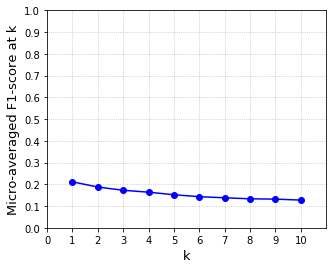

In [16]:
plt.clf()
ax = plt.gca()



# {'nn__n_neighbors': 50, 'vect__norm': 'l2', 'lda__n_components': 50, 'vect__max_features': 500, 'nn__metric': 'manhattan'}
validation_scores = [0.21155555555555555, 0.1873873873873874,
    0.17257039055404177 , 0.16381473876340405,
    0.1520940484937546, 0.1430549146285187,
    0.13802221047065044,  0.13336425837875449,
    0.13184772516248838, 0.1275011633317822]

ax = plt.gca()
plot_micro_f1_at_k(validation_scores,ax)
plt.gca().legend_.remove()

plt.gcf().set_size_inches(5,4)
plt.show()